In [ ]:
import os
import zipfile
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras.backend as K
K.set_image_data_format('channels_last')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1e0w9fMsIQJpFFqwa-TC2s_EVAqF1NoqF

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1e0w9fMsIQJpFFqwa-TC2s_EVAqF1NoqF
From (redirected): https://drive.google.com/uc?id=1e0w9fMsIQJpFFqwa-TC2s_EVAqF1NoqF&confirm=t&uuid=d4a3abdc-0522-44e4-a90b-9785b48d906a
To: /content/archive.zip
100% 445M/445M [00:11<00:00, 38.8MB/s]


In [ ]:


zip_path = 'archive.zip'
extract_path = '/content/extracted_dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def get_dataset_size(folder_path):
  total_files = 0
  for root, _, files in os.walk(folder_path):
    for file in files:
      if os.path.isfile(os.path.join(root, file)):
        total_files += 1
  return total_files

folder_path = "/content/extracted_dataset/"
dataset_size = get_dataset_size(folder_path)
print(f"The size of your dataset is {dataset_size} files.")


train_path = os.path.join(extract_path, 'train')

test_path = os.path.join(extract_path, 'test')


if os.path.exists(train_path):
    print(f"Train batch exists at {train_path}.")
else:
    print("No separate train batch found.")

if os.path.exists(test_path):
    print(f"Test batch exists at {test_path}.")
else:
    print("No separate test batch found.")

def get_classes(folder_path):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return classes

if os.path.exists(train_path):
    train_classes = get_classes(train_path)
    print(f"Classes in the train batch: {train_classes}")
if os.path.exists(test_path):
    test_classes = get_classes(test_path)
    print(f"Classes in the test batch: {test_classes}")



The size of your dataset is 14495 files.
Train batch exists at /content/extracted_dataset/train.
Test batch exists at /content/extracted_dataset/test.
Classes in the train batch: ['fencing', 'luge', 'rings', 'balance beam', 'bmx', 'sidecar racing', 'log rolling', 'sailboat racing', 'skydiving', 'volleyball', 'pole vault', 'table tennis', 'speed skating', 'curling', 'surfing', 'jai alai', 'cricket', 'hurdles', 'figure skating women', 'wheelchair racing', 'canoe slamon', 'lacrosse', 'parallel bar', 'snowmobile racing', 'cheerleading', 'shot put', 'uneven bars', 'shuffleboard', 'tug of war', 'horseshoe pitching', 'rollerblade racing', 'javelin', 'hockey', 'pole dancing', 'bike polo', 'tennis', 'figure skating men', 'motorcycle racing', 'horse racing', 'football', 'rowing', 'boxing', 'axe throwing', 'baton twirling', 'arm wrestling', 'baseball', 'ski jumping', 'bungee jumping', 'track bicycle', 'hang gliding', 'bobsled', 'rock climbing', 'formula 1 racing', 'croquet', 'air hockey', 'high j

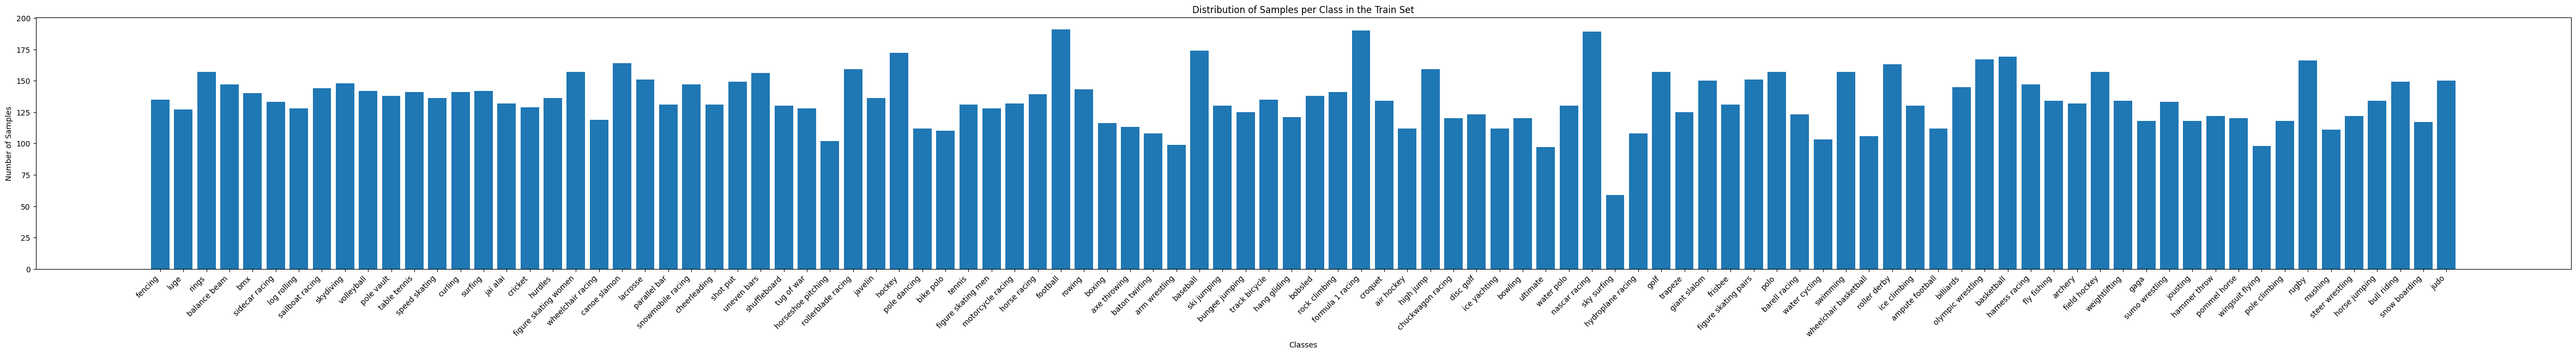

In [ ]:

def get_class_distribution(folder_path):
    class_distribution = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_samples = len(os.listdir(class_path))
            class_distribution[class_name] = num_samples
    return class_distribution


train_path = '/content/extracted_dataset/train'

train_class_distribution = get_class_distribution(train_path)
plt.figure(figsize=(60, 6))
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class in the Train Set')
plt.xticks(rotation=45, ha='right')
plt.show()


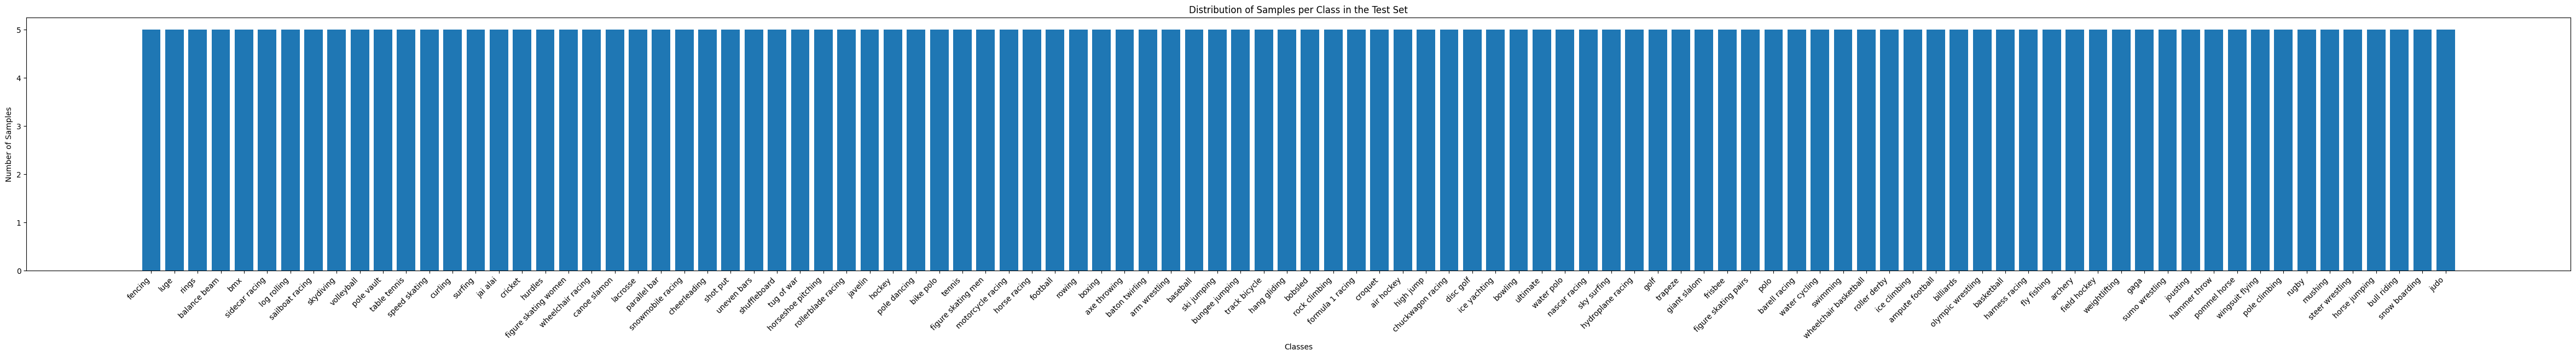

In [ ]:

test_path = '/content/extracted_dataset/test'

test_class_distribution = get_class_distribution(test_path)

plt.figure(figsize=(60, 6))
plt.bar(test_class_distribution.keys(), test_class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class in the Test Set')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
def get_classes(folder_path):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return classes

if os.path.exists(train_path):
    train_classes = get_classes(train_path)
    print(f"Classes in the train batch: {train_classes}")
if os.path.exists(test_path):
    test_classes = get_classes(test_path)
    print(f"Classes in the test batch: {test_classes}")

def load_and_preprocess_images(folder_path, target_size=(64, 64)):
    data = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path) and image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    image = Image.open(image_path).convert('L')  # Convert to grayscale
                    image = image.resize(target_size)
                    data.append(np.array(image).flatten())
                    labels.append(class_name)
    return np.array(data), np.array(labels)


X_train, y_train = load_and_preprocess_images(train_path)


X_test, y_test = load_and_preprocess_images(test_path)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
train_classification_report = classification_report(y_train, y_train_pred)

print("Results on the training set:")
print(f"Accuracy: {train_accuracy}")
print(f"Confusion Matrix:\n{train_conf_matrix}")
print(f"Classification Report:\n{train_classification_report}")

y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print("\nResults on the test set:")
print(f"Accuracy: {test_accuracy}")
print(f"Confusion Matrix:\n{test_conf_matrix}")
print(f"Classification Report:\n{test_classification_report}")


Classes in the train batch: ['fencing', 'luge', 'rings', 'balance beam', 'bmx', 'sidecar racing', 'log rolling', 'sailboat racing', 'skydiving', 'volleyball', 'pole vault', 'table tennis', 'speed skating', 'curling', 'surfing', 'jai alai', 'cricket', 'hurdles', 'figure skating women', 'wheelchair racing', 'canoe slamon', 'lacrosse', 'parallel bar', 'snowmobile racing', 'cheerleading', 'shot put', 'uneven bars', 'shuffleboard', 'tug of war', 'horseshoe pitching', 'rollerblade racing', 'javelin', 'hockey', 'pole dancing', 'bike polo', 'tennis', 'figure skating men', 'motorcycle racing', 'horse racing', 'football', 'rowing', 'boxing', 'axe throwing', 'baton twirling', 'arm wrestling', 'baseball', 'ski jumping', 'bungee jumping', 'track bicycle', 'hang gliding', 'bobsled', 'rock climbing', 'formula 1 racing', 'croquet', 'air hockey', 'high jump', 'chuckwagon racing', 'disc golf', 'ice yachting', 'bowling', 'ultimate', 'water polo', 'nascar racing', 'sky surfing', 'hydroplane racing', 'golf

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


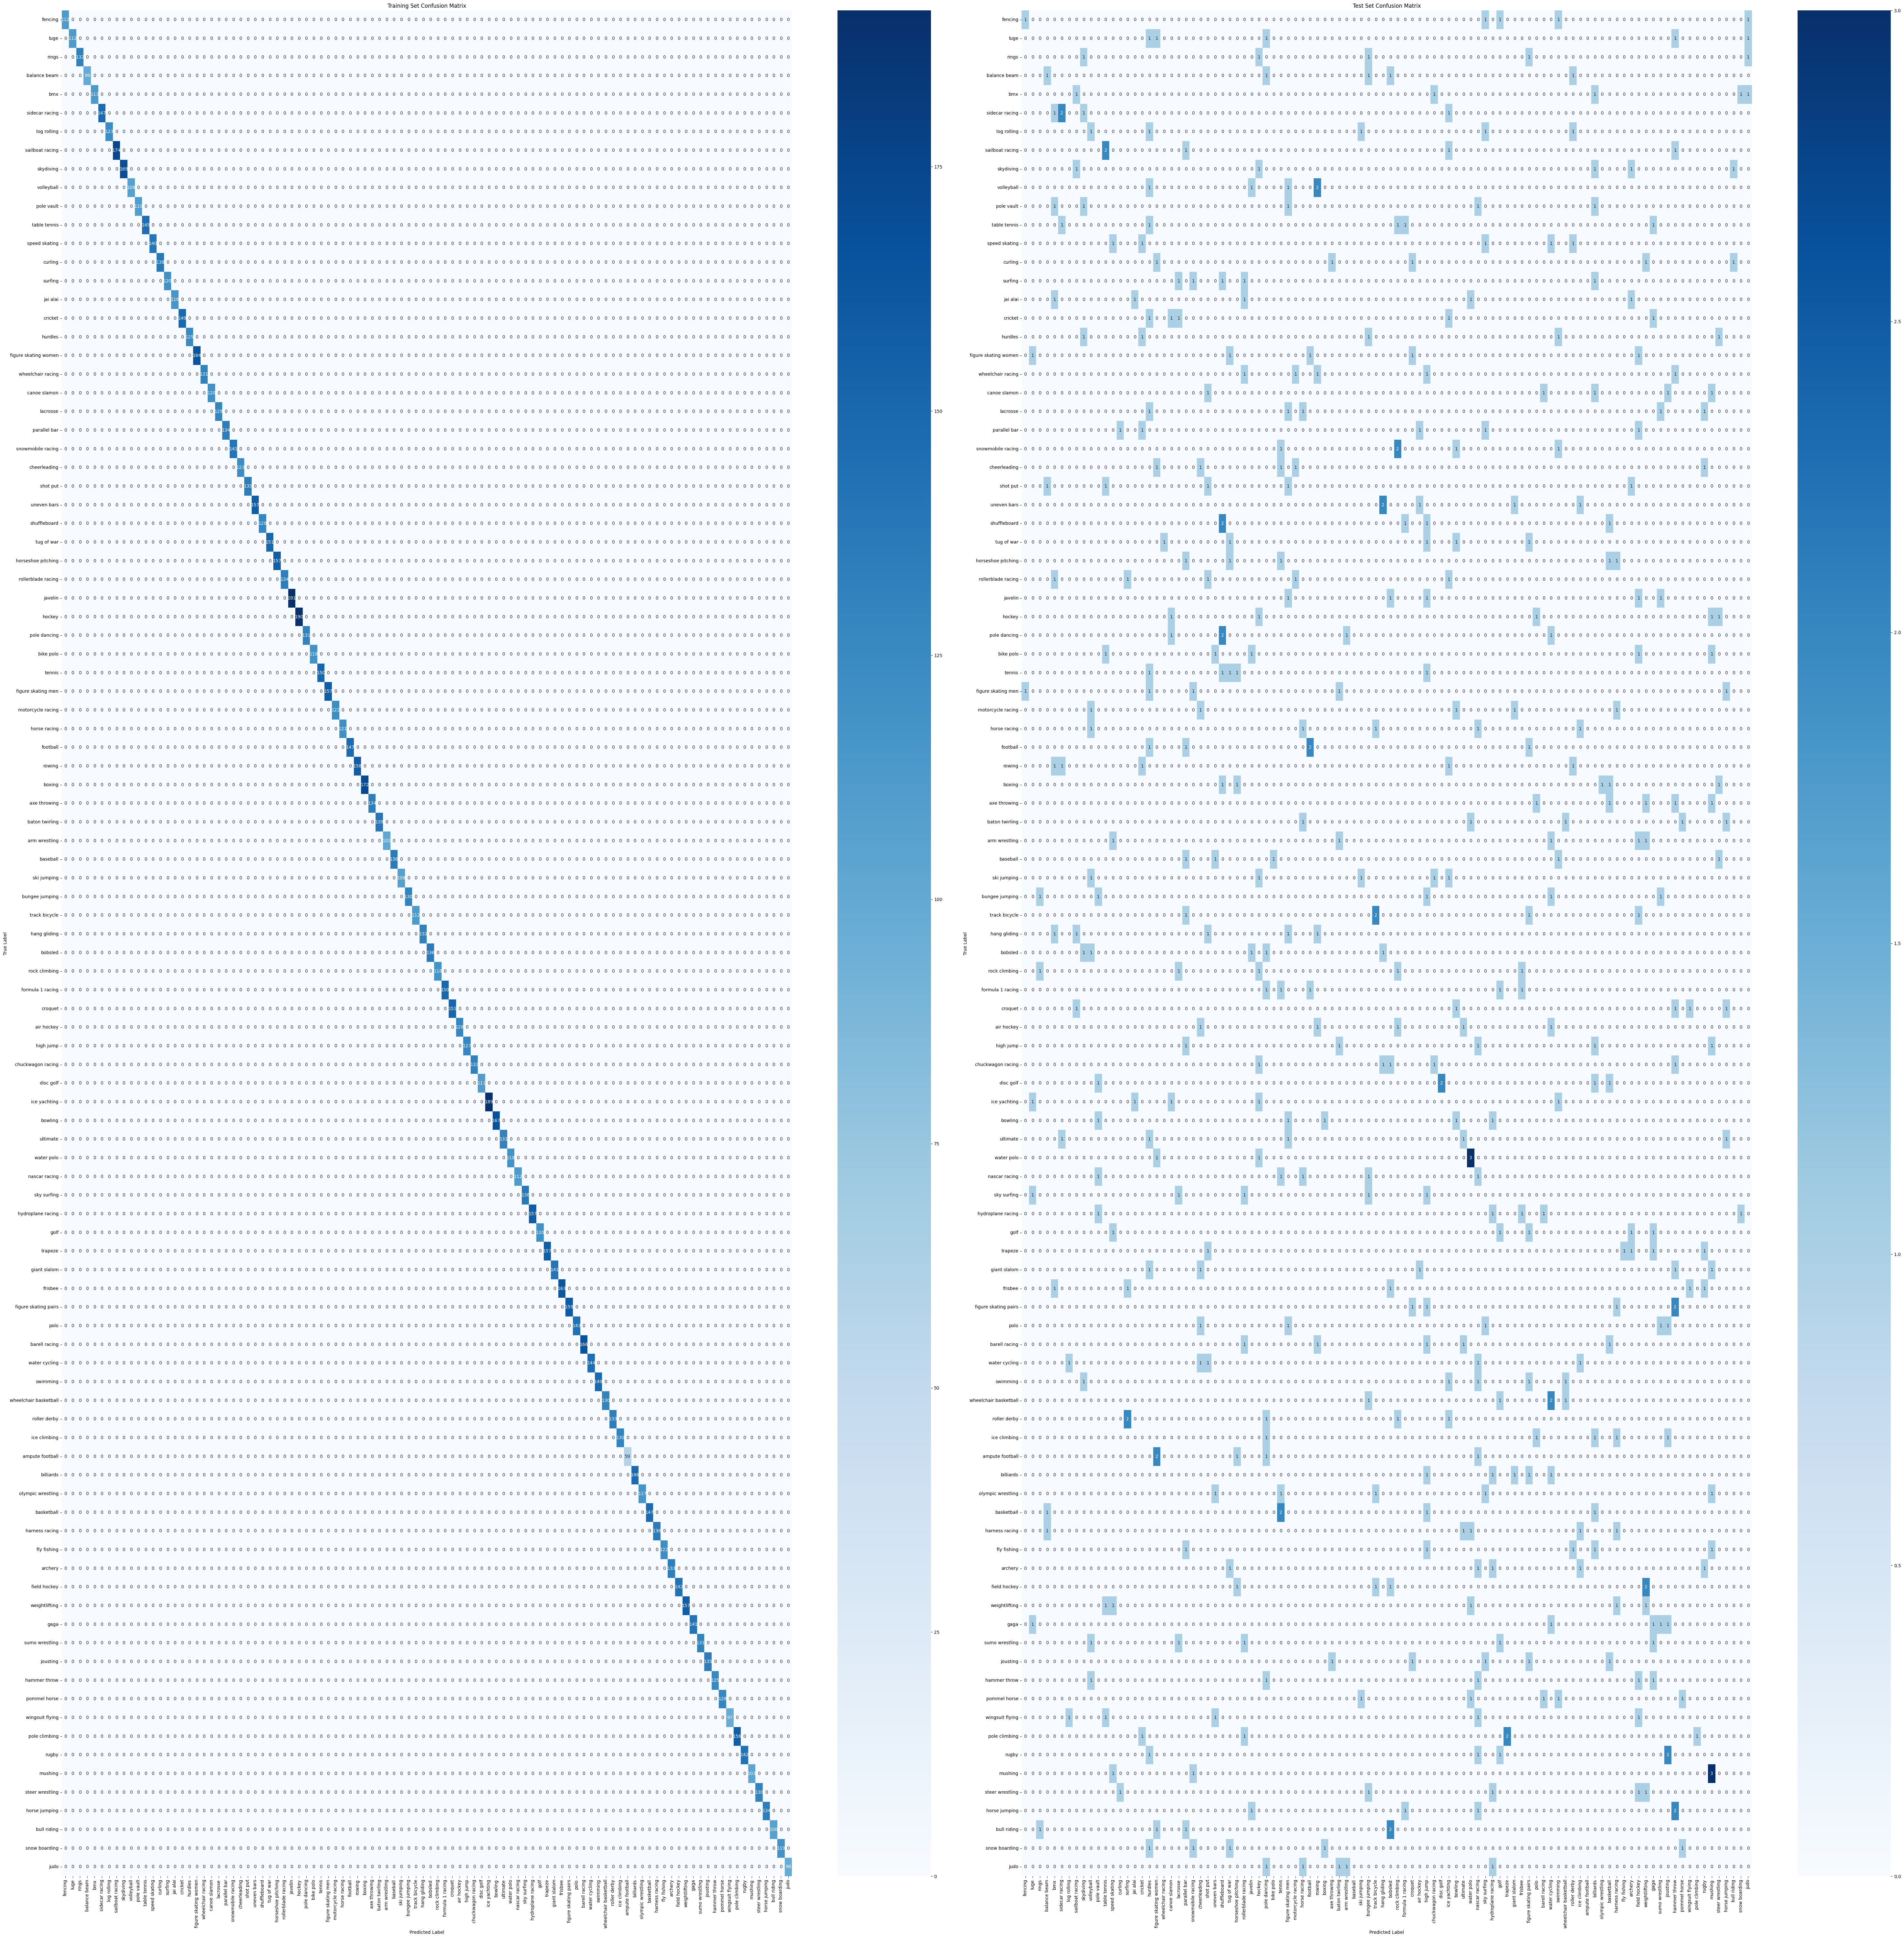

In [ ]:

plt.figure(figsize=(60, 60))


plt.subplot(1, 2, 1)
sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_classes, yticklabels=train_classes)
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_classes, yticklabels=test_classes)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

In [ ]:
X_train, y_train = load_and_preprocess_images(train_path)
X_test, y_test = load_and_preprocess_images(test_path)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_to_index = {label: index for index, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_to_index[label] for label in y_train])

model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(len(np.unique(y_train_numeric)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_numeric, epochs=30, batch_size=256)

train_results = model.evaluate(X_train, y_train_numeric)
print("Results on the training set:")
print(f"Accuracy: {train_results[1]}")

y_test_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_probs, axis=1)

y_test_numeric = np.array([label_to_index[label] for label in y_test])


test_accuracy = accuracy_score(y_test_numeric, y_test_pred)
test_conf_matrix = confusion_matrix(y_test_numeric, y_test_pred)
test_classification_report = classification_report(y_test_numeric, y_test_pred)

print("\nResults on the test set:")
print(f"Accuracy: {test_accuracy}")
print(f"Confusion Matrix:\n{test_conf_matrix}")
print(f"Classification Report:\n{test_classification_report}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.0115 - loss: 4.6264
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0283 - loss: 4.5501
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0330 - loss: 4.4877
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0349 - loss: 4.4172
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0454 - loss: 4.3514
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0494 - loss: 4.2861
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0600 - loss: 4.2312
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0639 - loss: 4.1752
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0689 - loss: 4.1224
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0784 - loss: 4.0701
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0833 - loss: 4.0351
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0906 - l

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


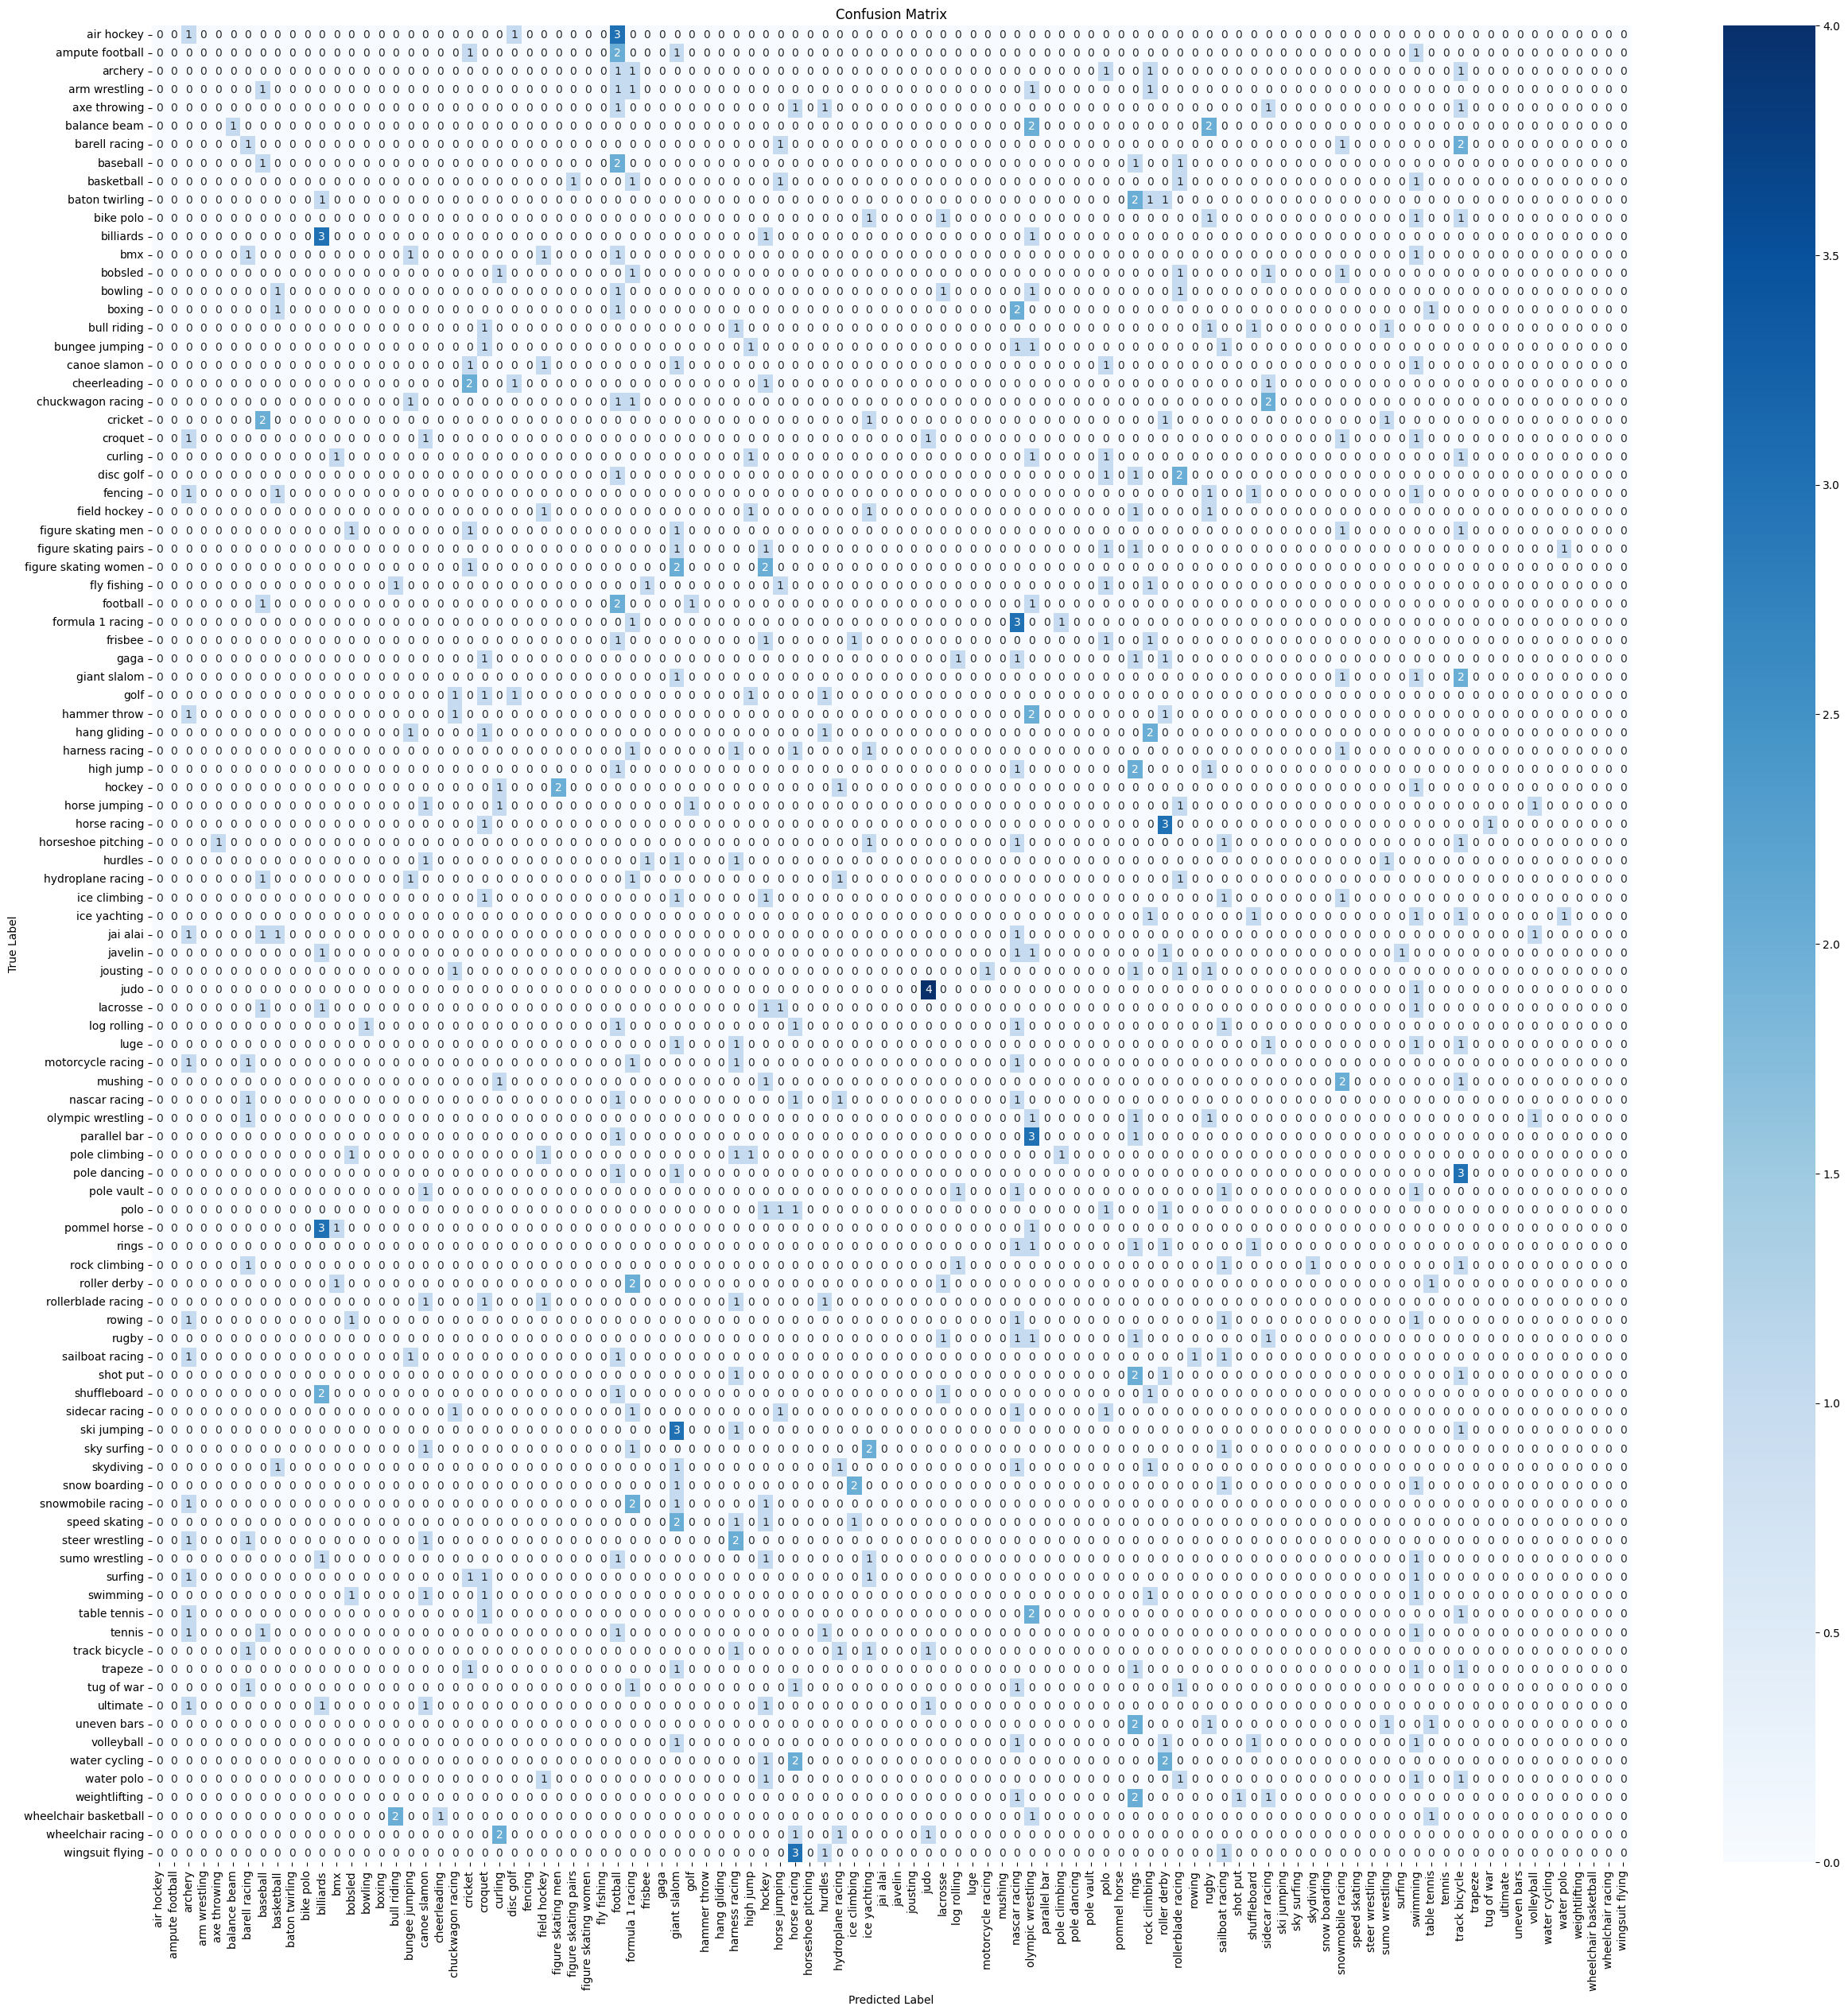

In [ ]:

conf_mat = confusion_matrix(y_test_numeric, y_test_pred)

plt.figure(figsize=(30, 30))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**AlexNet MODEL**
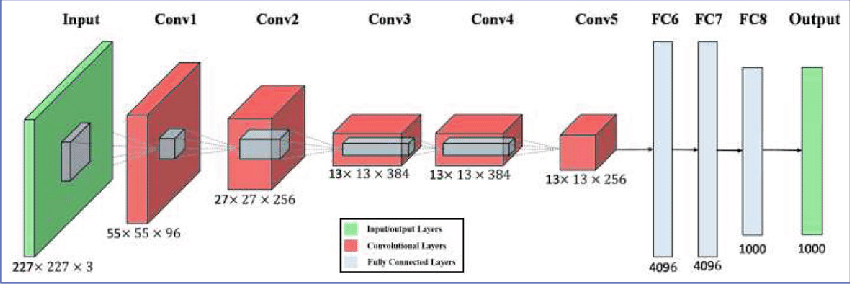

In [ ]:
#AlexNet
train_datagen = ImageDataGenerator(rescale=1. / 255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train = train_datagen.flow_from_directory(train_path, target_size=(227,227), class_mode='categorical')

Found 13492 images belonging to 100 classes.


In [ ]:
type(train)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [ ]:
type(train_datagen)

keras.src.legacy.preprocessing.image.ImageDataGenerator

In [ ]:
print("Batch Size for Input Image : ",train[0][0].shape)
print("Batch Size for Output Image : ",train[0][1].shape)
print("Image Size of first image : ",train[0][0][0].shape)
print("Output of first image : ",train[0][1][0].shape)

Batch Size for Input Image :  (32, 227, 227, 3)
Batch Size for Output Image :  (32, 100)
Image Size of first image :  (227, 227, 3)
Output of first image :  (100,)


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]')

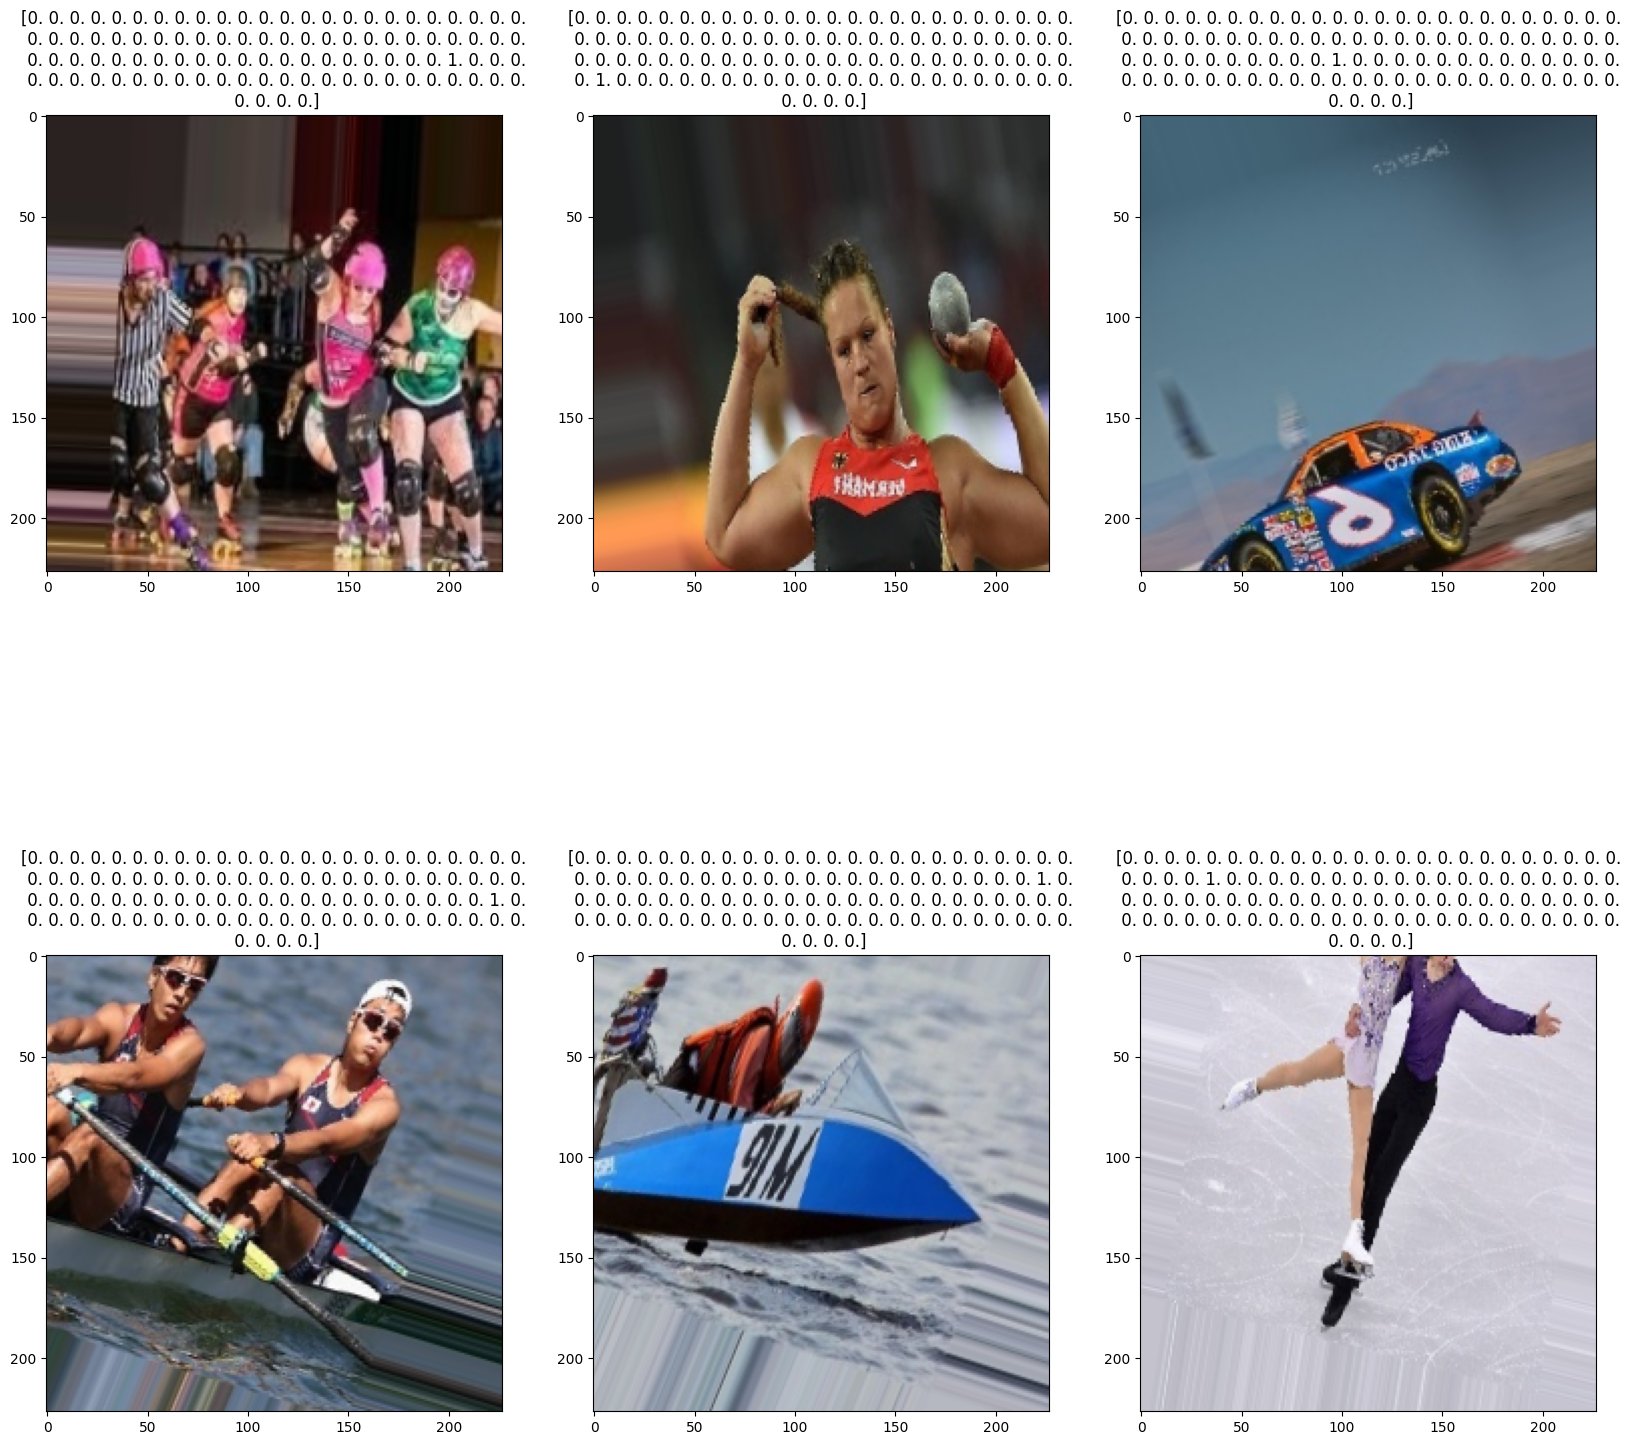

In [ ]:
fig , axs = plt.subplots(2,3 ,figsize = (20,20))
axs[0][0].imshow(train[0][0][12])
# Convert the array to a string representation
axs[0][0].set_title(str(train[0][1][12]))
axs[0][1].imshow(train[0][0][10])
axs[0][1].set_title(str(train[0][1][10]))
axs[0][2].imshow(train[0][0][5])
axs[0][2].set_title(str(train[0][1][5]))
axs[1][0].imshow(train[0][0][20])
axs[1][0].set_title(str(train[0][1][20]))
axs[1][1].imshow(train[0][0][25])
axs[1][1].set_title(str(train[0][1][25]))
axs[1][2].imshow(train[0][0][3])
axs[1][2].set_title(str(train[0][1][3]))

In [ ]:
def AlexNet(input_shape):

    X_input = Input(input_shape)

    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)

    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)

    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)

    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)

    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)

    X = Flatten()(X)

    X = Dense(4096, activation = 'relu', name = "fc0")(X)

    X = Dense(4096, activation = 'relu', name = 'fc1')(X)

    X = Dense(100,activation='softmax',name = 'fc2')(X)

    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    return model

In [ ]:

alex = AlexNet(train.image_shape)

In [ ]:
alex.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 55, 55, 96)          │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 55, 55, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max0 (MaxPooling2D)                  │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 27, 27, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 27, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 13, 13, 384)         │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 13, 13, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 13, 13, 384)         │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 13, 13, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 13, 13, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc0 (Dense)                          │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,696,548 (223.91 MB)

 Trainable params: 58,693,796 (223.90 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
alex.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
alex.fit(train,epochs=35)

Epoch 1/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 183s 407ms/step - accuracy: 0.0272 - loss: 9.1292
Epoch 2/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 171s 399ms/step - accuracy: 0.0606 - loss: 4.0251
Epoch 3/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 170s 398ms/step - accuracy: 0.0807 - loss: 3.8310
Epoch 4/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 396ms/step - accuracy: 0.0989 - loss: 3.6853
Epoch 5/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 173s 403ms/step - accuracy: 0.1228 - loss: 3.5384
Epoch 6/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 403ms/step - accuracy: 0.1520 - loss: 3.4105
Epoch 7/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 171s 400ms/step - accuracy: 0.1672 - loss: 3.2665
Epoch 8/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 397ms/step - accuracy: 0.1984 - loss: 3.1259
Epoch 9/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 402ms/step - accuracy: 0.2243 - loss: 2.9910
Epoch 10/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 171s 399ms/step - accuracy: 0.2382 - loss: 2.8955
Epoch 11/35
422/422 ━━━━━━━━━━━━━━━━━━━━ 175s 410ms/step - accuracy: 0.2632 - loss: 2.7614
Epoch 12

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test = test_datagen.flow_from_directory(test_path, target_size=(227,227), class_mode='categorical')

Found 500 images belonging to 100 classes.


In [ ]:
preds = alex.evaluate(test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5979 - loss: 1.4988
Loss = 1.5796750783920288
Test Accuracy = 0.5860000252723694


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


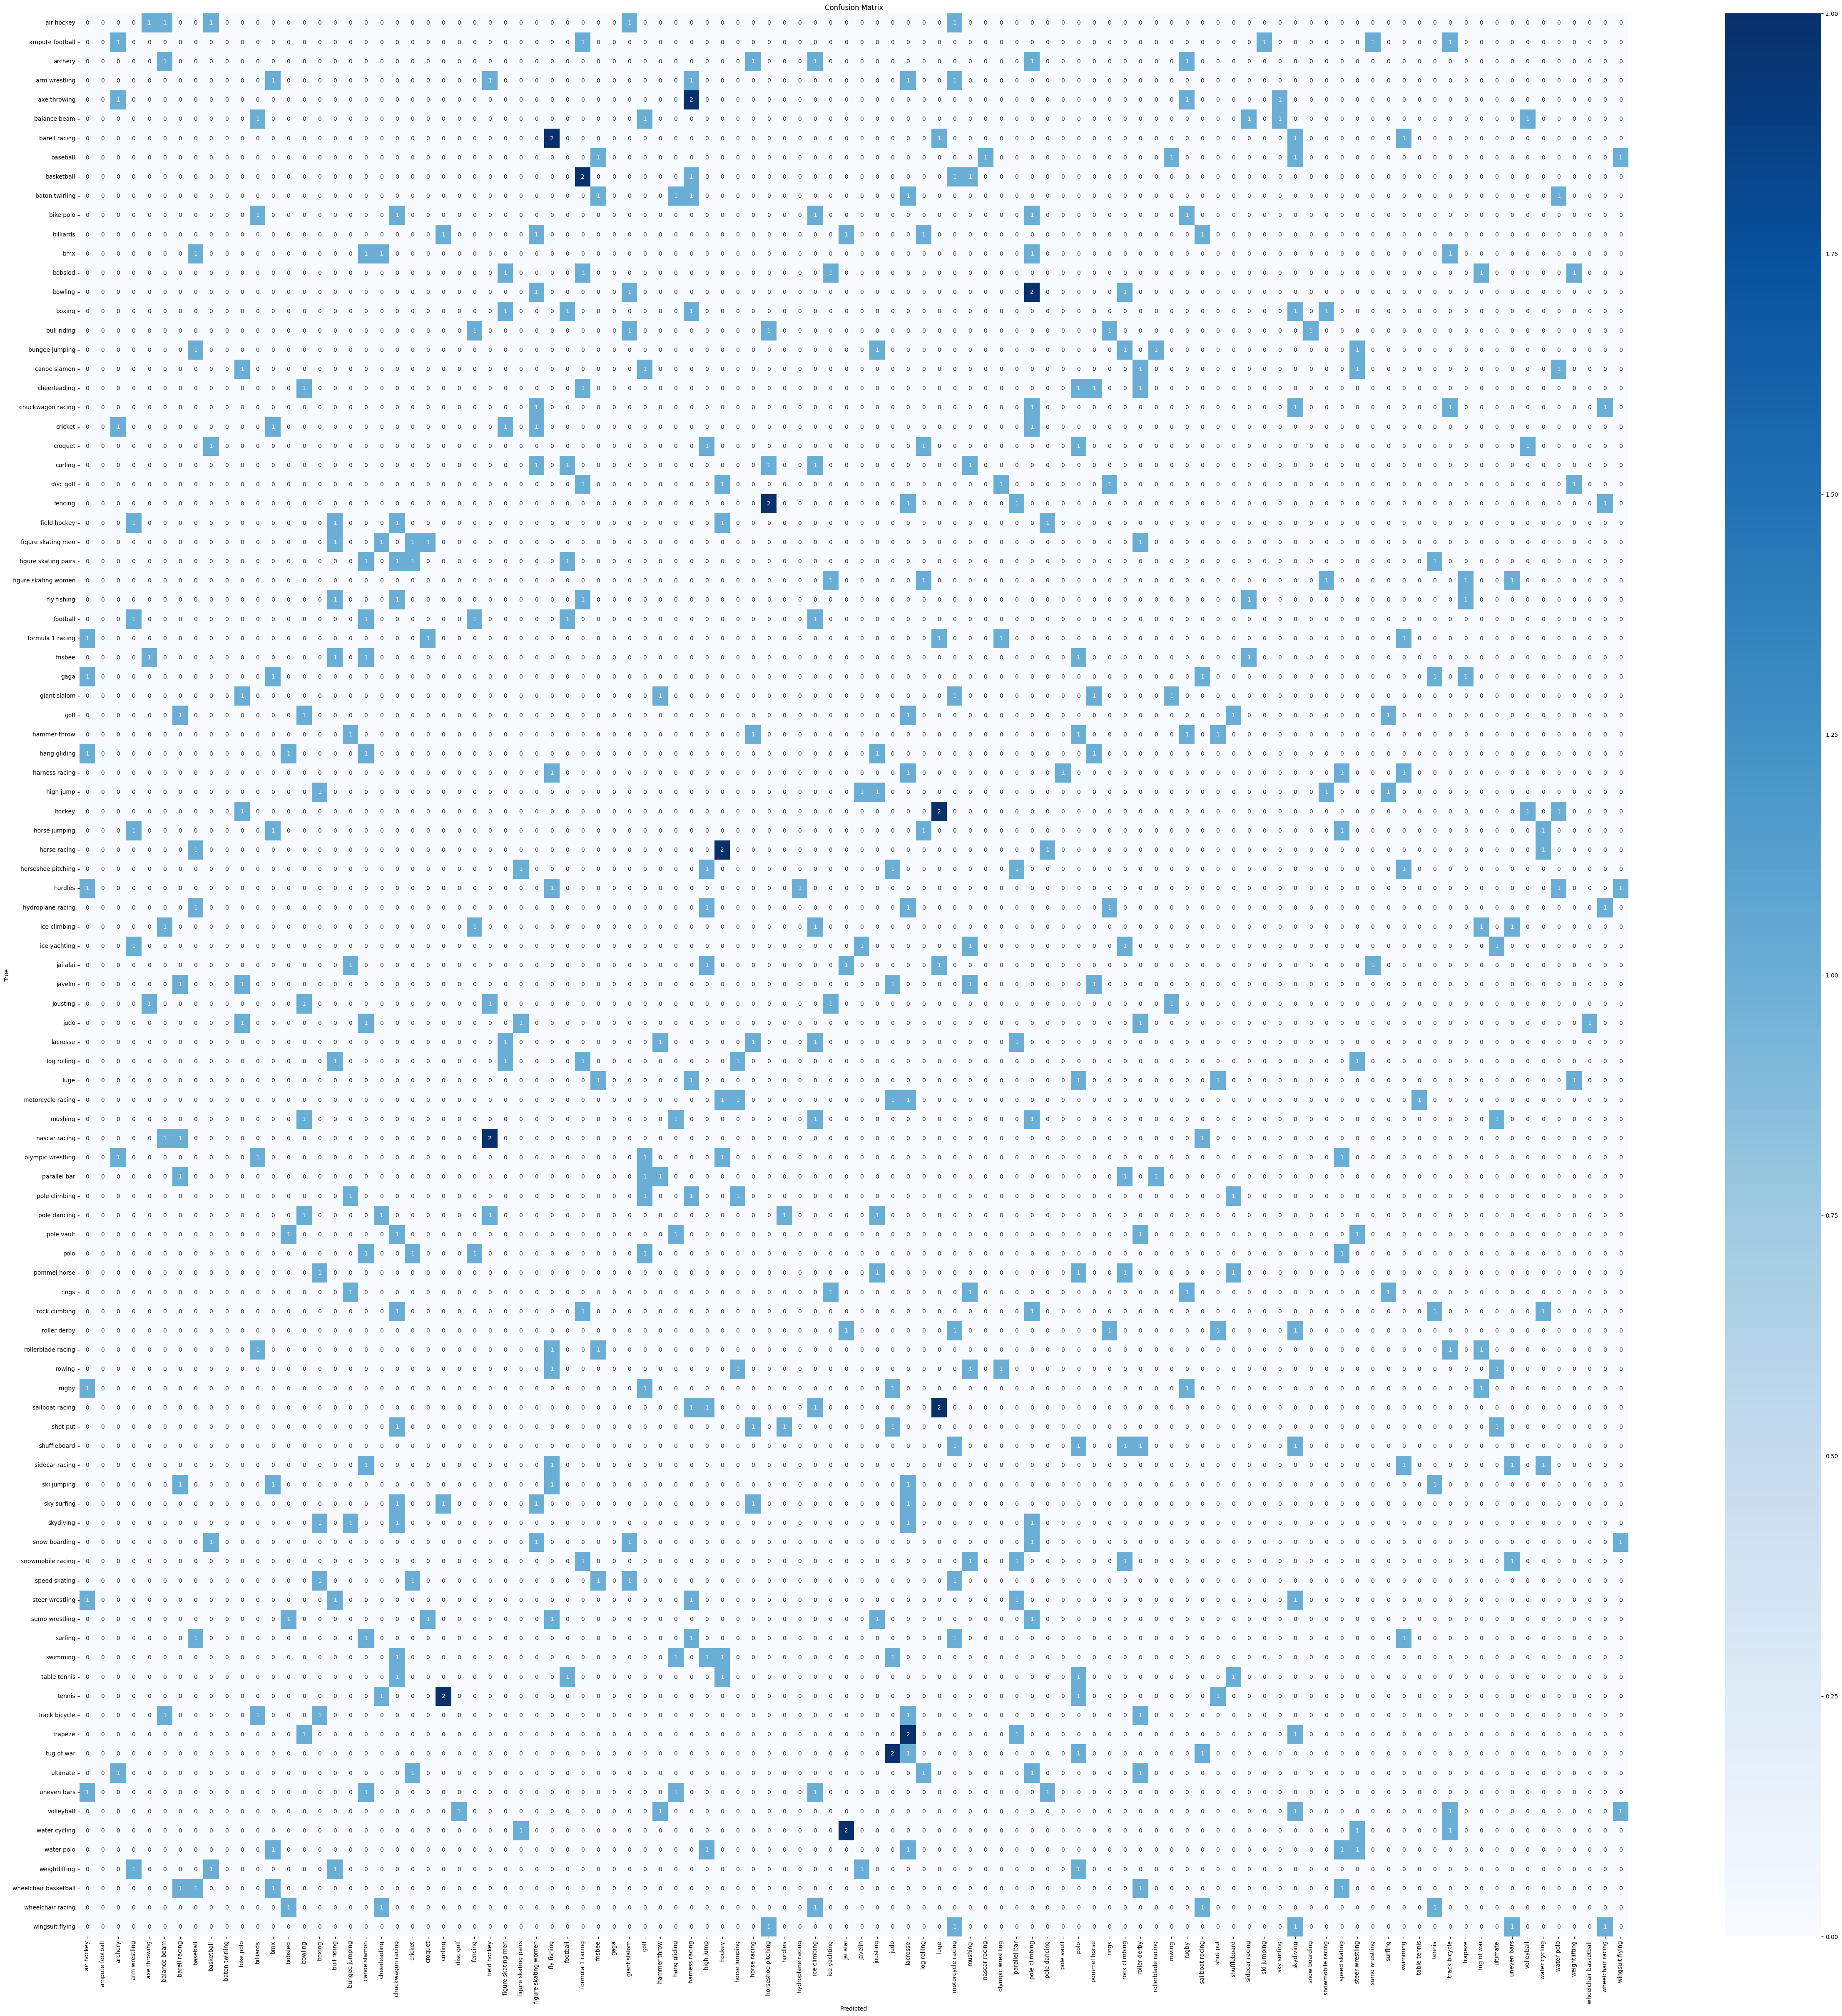

Classification Report:
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.00      0.00      0.00         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.00      0.00      0.00         5
         axe throwing       0.00      0.00      0.00         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.00      0.00      0.00         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.0

In [ ]:
# Calculate confusion matrix and classification report
Y_pred = alex.predict(test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test.classes
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=test.class_indices)

# Display confusion matrix
plt.figure(figsize=(60, 60))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test.class_indices.keys(),
            yticklabels=test.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print("Classification Report:")
print(class_report)

From the Classification Report we can see that the performance is equally good in all the classes. The accuracy can be improved by training the model more and so by increasing the epochs value in alex.fit(train,epochs=35). There were some Bad sample tests due to Overfitting and Hardware Limitations, there might also be some poor quality data in the large dataset.